<a href="https://colab.research.google.com/github/neuroqudit/pykoppu/blob/main/notebooks/05_portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Optimization with KOPPU

This notebook demonstrates how to solve the Portfolio Optimization problem using the KOPPU OPU. We aim to select a portfolio of assets that minimizes risk while maximizing expected return.

## 1. Problem Formulation

We use the Markowitz Mean-Variance model. The goal is to find a binary vector $x$ (where $x_i=1$ if asset $i$ is selected) that minimizes the following objective function:

$$ H = q \sum_{i,j} \sigma_{ij} x_i x_j - \sum_i \mu_i x_i $$

Where:
- $x_i \in \{0, 1\}$ is the binary decision variable for asset $i$.
- $\mu_i$ is the expected return of asset $i$.
- $\sigma_{ij}$ is the covariance between asset $i$ and asset $j$.
- $q$ is the risk aversion coefficient ($q > 0$). Higher $q$ prioritizes lower risk.

The first term represents the portfolio risk (variance), and the second term represents the expected return (which we subtract to maximize).

In [1]:
!pip install pykoppu==0.2.34a0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.9 MB/s eta 0:00:00


In [2]:
import pykoppu as pk
import numpy as np
import matplotlib.pyplot as plt

# 1. Define Assets
n_assets = 5
assets = [f"Asset {i+1}" for i in range(n_assets)]

# Expected Returns (mu)
mu = np.array([0.1, 0.2, 0.15, 0.05, 0.25])

# Covariance Matrix (sigma)
# Diagonal: Variance (Risk)
# Off-diagonal: Correlation
sigma = np.array([
    [0.01, 0.002, 0.005, 0.0, 0.001],
    [0.002, 0.04, 0.01, 0.001, 0.005],
    [0.005, 0.01, 0.02, 0.002, 0.003],
    [0.0, 0.001, 0.002, 0.005, 0.001],
    [0.001, 0.005, 0.003, 0.001, 0.05]
])

risk_aversion = 0.5

## 2. PUBO Mapping

The problem is already in quadratic form (QUBO/PUBO). We map it to the OPU Hamiltonian:

$$ H = -\frac{1}{2} x^T J x - h^T x $$

Comparing terms:
- Quadratic term: $q \sigma_{ij} x_i x_j$ maps to $-\frac{1}{2} J_{ij} x_i x_j$. Thus $J_{ij} = -2 q \sigma_{ij}$.
- Linear term: $-\mu_i x_i$ maps to $-h_i x_i$. Thus $h_i = \mu_i$.

### Tensors and Solver Process

1.  **Tensors**: The covariance matrix is scaled by $-2q$ to form the coupling tensor $J$. The expected returns form the bias vector $h$.
2.  **Solver Process**: The OPU relaxes to the ground state. The negative coupling (from positive covariance) acts as inhibition, discouraging selecting correlated assets. The positive bias (from returns) encourages selecting high-return assets.

Mapping to OPU...
Solving...
Visualizing OPU Dynamics...


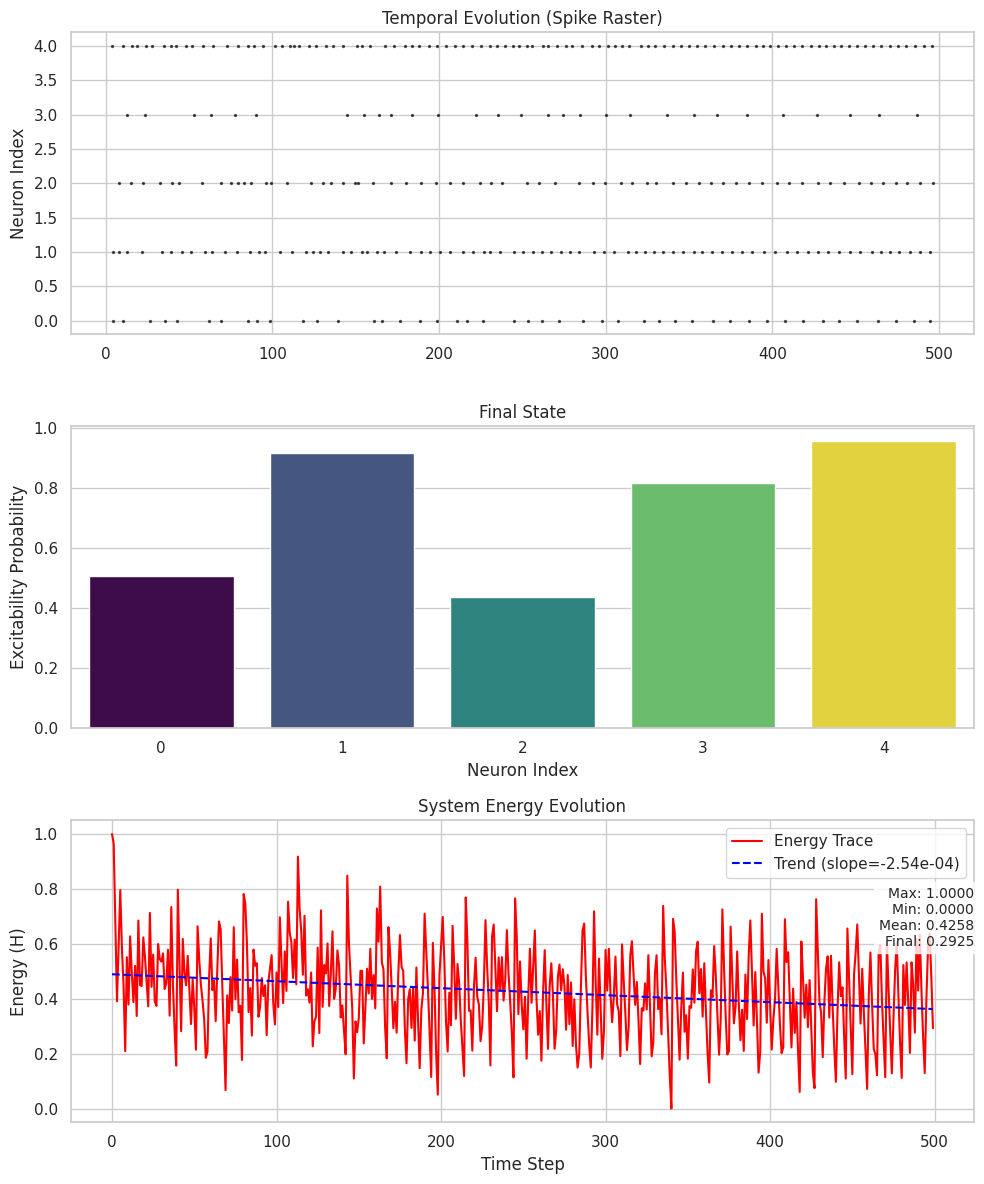

In [3]:
# 2. Create Portfolio Problem
print("Mapping to OPU...")
problem = pk.problems.finance.PortfolioOptimization(mu, sigma, risk_aversion)

# 3. Solve
print("Solving...")
process = pk.oos.Process(problem, backend='cpu', t=500)
result = process.run()

# 4. Display OPU Dynamics
print("Visualizing OPU Dynamics...")
result.plot()

## 3. Solution Analysis

We analyze the selected portfolio. Assets with final state close to 1 are selected.

In [4]:
# 5. Analyse Solution
print("\nSelected Portfolio:")
threshold = 0.5
x = (result.solution >= threshold).astype(int)

total_return = 0
total_risk = 0

for i in range(n_assets):
    if x[i] == 1:
        print(f"- {assets[i]} (Return: {mu[i]:.2f}, Risk: {sigma[i,i]:.3f})")
        total_return += mu[i]

# Calculate portfolio risk
portfolio_risk = x.T @ sigma @ x
print(f"\nTotal Expected Return: {total_return:.2f}")
print(f"Portfolio Risk (Variance): {portfolio_risk:.4f}")


Selected Portfolio:
- Asset 1 (Return: 0.10, Risk: 0.010)
- Asset 2 (Return: 0.20, Risk: 0.040)
- Asset 4 (Return: 0.05, Risk: 0.005)
- Asset 5 (Return: 0.25, Risk: 0.050)

Total Expected Return: 0.60
Portfolio Risk (Variance): 0.1250
